In [155]:
import pandas as pd
import numpy as np, os
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Dropout, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Pre processing

In [2]:
folder_path = f"C:/Users/cricr/PycharmProjects/AI-proj/signals_no_artificats/128"

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_128.csv')]

# Initialize an empty DataFrame to concatenate all data
all_data = pd.DataFrame()
all_data_list = []
# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

In [3]:
folder_path = f"C:/Users/cricr/PycharmProjects/AI-proj/signals_no_artificats/250"

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_250.csv')]

# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now 'all_data_list' contains a list of all data from all CSV files

In [4]:
# Segment each patient's signal
#Voglio window size di 5 secondi
# --> 128 samples/s *5s = 640
window_size = 100

column_names = ['id', 'segment_values', 'label']
df_segments_patients_all = pd.DataFrame(columns=column_names)

id = 0

for patient_data in all_data_list:
    patient_signal = patient_data['value'].values
    for i in range(0, len(patient_signal) - window_size + 1, window_size):
     
        segment = patient_signal[i:i+window_size]
        
        for j in range(i, i+window_size):
            if(patient_data['IsPeak'].values[j] == True):
                #Add segment to list only if in the considered window there is a peak
                df_segments_patient_temp = pd.DataFrame({'id': id,
                                        'segment_values': [segment],
                                        'label': patient_data['PeakNature'].values[j]})
                df_segments_patients_all = pd.concat([df_segments_patients_all, df_segments_patient_temp], ignore_index=True)
                break
                
    id = id + 1

In [141]:
file_name = f"C:/Users/cricr/PycharmProjects/AI-proj/patients_segmented.csv"
df_segments_patients_all.to_csv(file_name, sep=',', index=False, encoding='utf-8')

# Train / Val / Test split

In [142]:
num_patients = df_segments_patients_all['id'].nunique()

train_indices = np.random.choice(range(num_patients), size=int(num_patients * 0.7), replace=False)
validation_indices = np.random.choice(list(set(range(num_patients)) - set(train_indices)), size=int(num_patients * 0.15), replace=False)
test_indices = list(set(range(num_patients)) - set(train_indices) - set(validation_indices))


In [143]:
train_df = df_segments_patients_all[df_segments_patients_all['id'].isin(train_indices)].drop(['id'], axis=1)
# Split dataframe into features and labels
X_train = train_df.drop(['label'], axis=1).values
y_train = train_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_train_list = train_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_train_df = pd.DataFrame(X_train_list)
X_train_np = X_train_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_train, columns=['label'])
one_hot_encoded_array_train = one_hot_encoded_df.values

In [144]:
validation_df = df_segments_patients_all[df_segments_patients_all['id'].isin(validation_indices)].drop(['id'], axis=1)
# Split dataframe into features and labels
X_validation = validation_df.drop(['label'], axis=1).values
y_validation = validation_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_validation_list = validation_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_validation_df = pd.DataFrame(X_validation_list)
X_val_np = X_validation_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_validation, columns=['label'])
one_hot_encoded_array_validation = one_hot_encoded_df.values

In [145]:
test_df = df_segments_patients_all[df_segments_patients_all['id'].isin(test_indices)].drop(['id'], axis=1)
# Split dataframe into features and labels
X_test = test_df.drop(['label'], axis=1).values

y_test = test_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_test_list = test_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_test_df = pd.DataFrame(X_test_list)
X_test_np = X_test_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_test, columns=['label'])
one_hot_encoded_array_test = one_hot_encoded_df.values

# Model

In [178]:
# Define a simple 1D CNN model
model = Sequential([
    Input(shape=(window_size, 1)),
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    
    Dense(614, activation='relu'),
    Dropout(0.3),
    Activation('relu'),
    Dense(3, activation='softmax')
])

In [179]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 98, 64)            │        256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_10 (Conv1D)              │ (None, 96, 128)           │     24,704 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 96, 128)           │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_1 (Activation)       │ (None, 96, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 48, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_6 (Flatten)             │ (None, 6144)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 70)                │    430,150 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 70)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_2 (Activation)       │ (None, 70)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 3)                 │        213 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 455,835 (1.74 MB)

 Trainable params: 455,579 (1.74 MB)

 Non-trainable params: 256 (1.00 KB)

In [180]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy', 'Precision', 'Recall' ])

In [181]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will stop
    verbose=1,
    restore_best_weights=True  # Restore the best model weights when training stops
)

In [184]:
nN = np.count_nonzero(y_train == 'N')
nV = np.count_nonzero(y_train == 'V')
nS = np.count_nonzero(y_train == 'S')

class_sum = nN+nV+nS
wN = round(1-(nN/class_sum),2)
wV = round(1-(nV/class_sum),2)  
wS = round(1-(nS/class_sum),2)

class_weights_fed = {0: wN, 1: wV, 2: wS}

print(class_weights_fed)

{0: 0.06, 1: 0.97, 2: 0.97}


In [185]:
# Train the model on the training set
history = model.fit(X_train_np, 
                    one_hot_encoded_array_train, 
                    epochs=30, 
                    callbacks=[early_stopping],
                    class_weight = class_weights_fed,
                    validation_data=(X_val_np, one_hot_encoded_array_validation))

Epoch 1/30
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - Accuracy: 0.8283 - Precision: 0.9101 - Recall: 0.5344 - loss: 0.1263 - val_Accuracy: 0.9426 - val_Precision: 0.9747 - val_Recall: 0.8060 - val_loss: 0.4149
Epoch 2/30
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - Accuracy: 0.9031 - Precision: 0.9493 - Recall: 0.6754 - loss: 0.0969 - val_Accuracy: 0.7677 - val_Precision: 0.9057 - val_Recall: 0.5303 - val_loss: 0.8861
Epoch 3/30
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - Accuracy: 0.9054 - Precision: 0.9553 - Recall: 0.6676 - loss: 0.0970 - val_Accuracy: 0.9577 - val_Precision: 0.9841 - val_Recall: 0.7650 - val_loss: 0.3585
Epoch 4/30
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - Accuracy: 0.9111 - Precision: 0.9537 - Recall: 0.6799 - loss: 0.0938 - val_Accuracy: 0.9485 - val_Precision: 0.9781 - val_Recall: 0.8137 - val_loss: 0.3547
Epoch 5/30
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - Accuracy: 0.9093 - Precision: 0.9507 - Recall: 0.6861 - loss: 0.0931 - val_Accuracy: 0

# Evaluate

In [186]:
test_loss, test_accuracy = model.evaluate(X_test_np, one_hot_encoded_array_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Accuracy: 0.8903 - Precision: 0.9398 - Recall: 0.7349 - loss: 0.4061


ValueError: too many values to unpack (expected 2)

In [187]:
def model_evaluation(y_predi, model_name_pred):
    predicted_class = np.argmax(y_predi, axis=-1)
    test_classes = np.argmax(one_hot_encoded_array_test, axis=-1)
    cm = confusion_matrix(test_classes, predicted_class)
    classes_name = ['N', 'S', 'V']

    #Normalized cm

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True,
                fmt='.2f')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.title(model_name_pred)
    plt.show()

789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


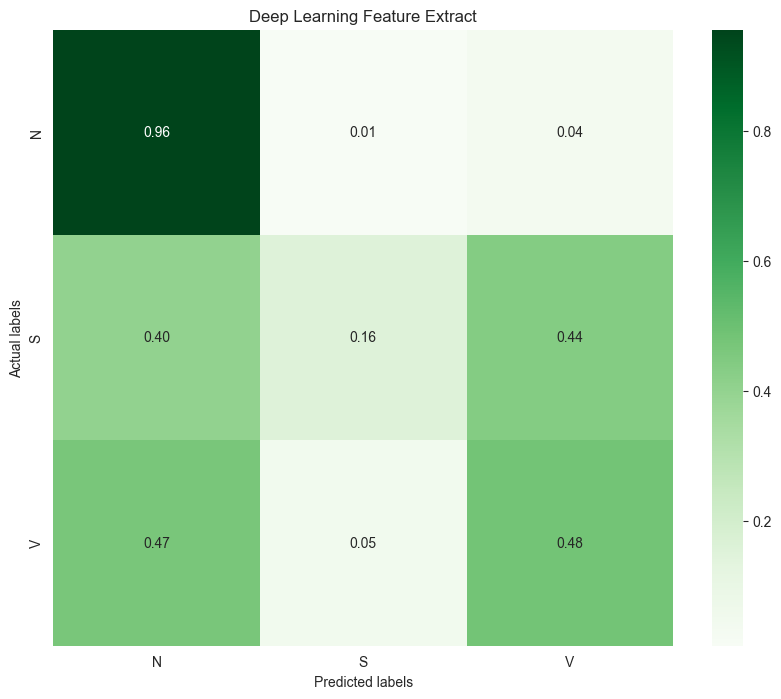

In [188]:
y_predi = model.predict(X_test_np)

model_evaluation(y_predi, "Deep Learning Feature Extract")